### Libraries

In [1]:
import gym
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
env= gym.make('Blackjack-v0')

#environment info
print(env.observation_space)
print(env.action_space)

#number of actions
nactions = env.action_space.n
print(nactions)

Tuple(Discrete(32), Discrete(11), Discrete(2))
Discrete(2)
2


### Testing BlackJack env with random actions

In [3]:
for i in range(3):
    state=env.reset()
    done= False
    while not done:
        action=env.action_space.sample()
        next_state, reward, done, _ = env.step(action)
        state=next_state
        if done: 
            if reward>0:
                res = "Win"
            else: 
                res="Defeat"
            print(f"Episode: {i}, Result: {res}")

Episode: 0, Result: Defeat
Episode: 1, Result: Defeat
Episode: 2, Result: Defeat


## First Visit Monte Carlo Prediction

### Helper functions

In [4]:
def custom_policy(state):
    """Returns actions based on the custom policy where agent sticks with 80% prob if sum>18 
    and hits with 80% probability otherwise"""
    
    probs = [0.8, 0.2] if state[0] > 18 else [0.2, 0.8]
    action = np.random.choice(np.arange(2), p=probs)
    return action

def get_returns(rewards, gamma):
    """Takes rewards trajectory of a episode and generates discounted returns 
    for each step of the given episode"""
    g= []
    g.append(rewards[-1])
    for i in range(len(rewards)-2,-1,-1):
        gt = rewards[i]+gamma*g[-1] 
        g.append(gt)
    g.reverse()
    return g

def generate_rollout_pred(gamma):
    """Generates a single episode for MC prediction with the given policy and 
    returns state, action and discounted return for each step"""
    
    s,a,r = [],[],[]
    state=env.reset()
    done= False
    while not done:
        action = custom_policy(state)
        next_state, reward, done, _ = env.step(action)
        state=next_state
        s.append(state)
        a.append(action)
        r.append(reward)
    g = get_returns(r,gamma)
    return s,a,g

def plot(V):
    """Plots state value function"""
    
    def get_Z(x, y, usable_ace):
        if (x,y,usable_ace) in V:
            return V[x,y,usable_ace]
        else:
            return 0

    def get_figure(usable_ace, ax):
        x_range = np.arange(11, 22)
        y_range = np.arange(1, 11)
        X, Y = np.meshgrid(x_range, y_range)
        
        Z = np.array([get_Z(x,y,usable_ace) for x,y in zip(np.ravel(X), np.ravel(Y))]).reshape(X.shape)

        surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=plt.cm.coolwarm, vmin=-1.0, vmax=1.0)
        ax.set_xlabel('Player\'s Current Sum')
        ax.set_ylabel('Dealer\'s Showing Card')
        ax.set_zlabel('State Value')
        ax.view_init(ax.elev, -120)

    fig = plt.figure(figsize=(20, 20))
    ax = fig.add_subplot(211, projection='3d')
    ax.set_title('Usable Ace')
    get_figure(True, ax)
    ax = fig.add_subplot(212, projection='3d')
    ax.set_title('No Usable Ace')
    get_figure(False, ax)
    plt.show()

### Parameters

In [5]:
#random state
seed = 0
num_eps = 500000

#Discount rate
gamma=1

### Algorithm 

In [6]:
np.random.seed(seed) 

#Initialze count and action value functions
N= defaultdict(lambda: np.zeros((nactions,)))
Q= defaultdict(lambda: np.zeros((nactions,)))

for i in range(1,num_eps+1):
    #Generate a single episode trajectory
    s,a,g = generate_rollout_pred(gamma)
    
    #Initialize a set for checking first state, action pair
    sa_set= set()
    #Iterate over each step of episode
    for t in range(len(s)):
        #If state, action pair is visited for first time
        if (s[t],a[t]) not in sa_set:
            #update count and action value 
            N[s[t]][a[t]] +=1
            tmp = Q[s[t]][a[t]] 
            Q[s[t]][a[t]] = tmp + (g[t]-tmp)/(N[s[t]][a[t]])
            #add the pair once visited
            sa_set.add((s[t],a[t]))
print(f'Training done for {num_eps} episodes')

Training done for 500000 episodes


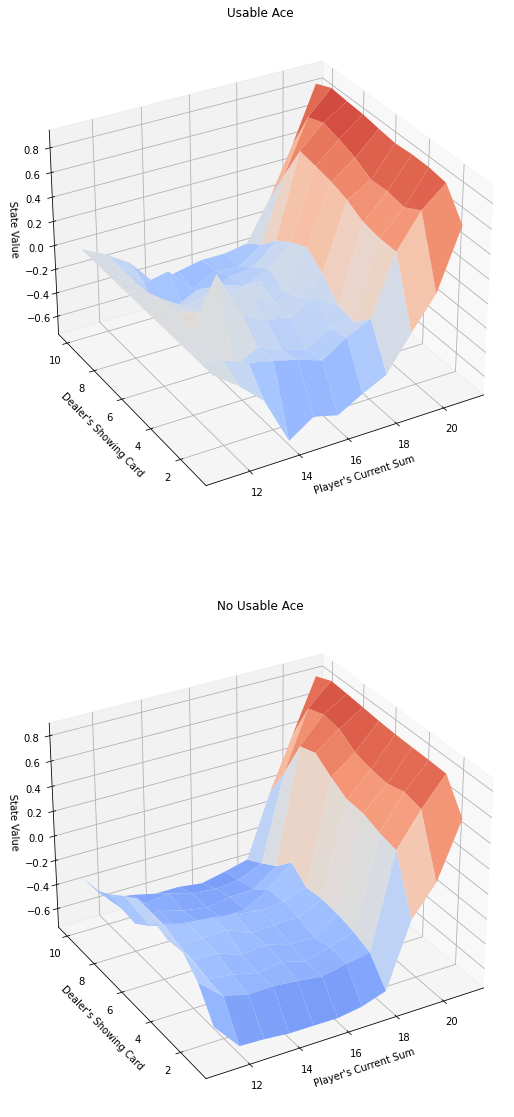

In [7]:
#Generate state value function from the predicted action value function for the custom policy
V={}
for s in Q:
    if s[0]>18:
        V[s] = 0.8*Q[s][0] + 0.2*Q[s][1]
    else:
        V[s] = 0.2*Q[s][0] + 0.8*Q[s][1]
    
plot(V)

## First Visit GLIE  Monte Carlo Control

### Helper functions

In [8]:
def eps_greedy(Q,state,eps):
    """Implements epsilon greedy stratetgy for selecting actions based on exploration exploitation tradeoff"""
    prob = np.ones((nactions,)) * eps/nactions
    prob[np.argmax(Q[state])] = 1 - eps + eps/nactions
    action = np.random.choice(np.arange(nactions), p=prob)
    return action

def generate_rollout(Q, gamma, eps):
    """Generates a single episode trajectory based on epsilon greedy policy and 
    returns state,action, discounted returns for each step"""
    s,a,r = [],[],[]
    state=env.reset()
    done= False
    while not done:
        if state not in Q:
            action = env.action_space.sample()
        else:
            action = eps_greedy(Q, state, eps)
        next_state, reward, done, _ = env.step(action)
        state=next_state
        s.append(state)
        a.append(action)
        r.append(reward)
    g = get_returns(r,gamma)
    return s,a,g

def plot_policy(policy):
    """Plots the policy as a 2D grid based on state, where grids are mapped to actions based on optimal policy"""

    def get_Z(x, y, usable_ace):
        if (x,y,usable_ace) in policy:
            return policy[x,y,usable_ace]
        else:
            return 1

    def get_figure(usable_ace, ax):
        x_range = np.arange(11, 22)
        y_range = np.arange(10, 0, -1)
        X, Y = np.meshgrid(x_range, y_range)
        Z = np.array([[get_Z(x,y,usable_ace) for x in x_range] for y in y_range])
        surf = ax.imshow(Z, cmap=plt.get_cmap('Pastel2', 2), vmin=0, vmax=1, extent=[10.5, 21.5, 0.5, 10.5])
        plt.xticks(x_range)
        plt.yticks(y_range)
        plt.gca().invert_yaxis()
        ax.set_xlabel('Player\'s Current Sum')
        ax.set_ylabel('Dealer\'s Showing Card')
        ax.grid(color='w', linestyle='-', linewidth=1)
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.1)
        cbar = plt.colorbar(surf, ticks=[0,1], cax=cax)
        cbar.ax.set_yticklabels(['0 (STICK)','1 (HIT)'])
            
    fig = plt.figure(figsize=(15, 15))
    ax = fig.add_subplot(121)
    ax.set_title('Usable Ace')
    get_figure(True, ax)
    ax = fig.add_subplot(122)
    ax.set_title('No Usable Ace')
    get_figure(False, ax)
    plt.show()

### Parameters

In [ ]:
seed = 0
num_eps = 700000
#discount rate
gamma=1

#initial exploration factor
eps= 1
#decay rate
eps_decay = 0.9999
#minimum exploration
eps_fin = 0.05

#Uncomment this for Constant-alpha MC control
# alpha = 0.02

### Algorithm 

In [10]:
np.random.seed(seed) 

#Initialze count and action value functions

#comment this for Constant-alpha MC control
N= defaultdict(lambda: np.zeros((nactions,)))

Q= defaultdict(lambda: np.zeros((nactions,)))

#track reward history
reward_his=[]

#Iterate over sample episodes
for i in range(1,num_eps+1):
    #Set epsilon for epsilon-greedy policy
    eps = max(eps*eps_decay, eps_fin)
    #Generate single episode trajectory
    s,a,g = generate_rollout(Q,gamma,eps)
    #Track the episode reward 
    reward_his.append(g[-1])
    #Initialize set for first visit check
    sa_set= set()
    for t in range(len(s)):
        if (s[t],a[t]) not in sa_set:
            tmp = Q[s[t]][a[t]]
            
            #comment this for Constant-alpha MC control
            N[s[t]][a[t]] +=1
            Q[s[t]][a[t]] = tmp + (g[t]-tmp)/(N[s[t]][a[t]])
            
            #Uncomment this for Constant-alpha MC control
            #Q[s[t]][a[t]] = tmp + alpha*(g[t]-tmp)
            
            sa_set.add((s[t],a[t]))
print(f'Training done for {num_eps} episodes')

Training done for 700000 episodes


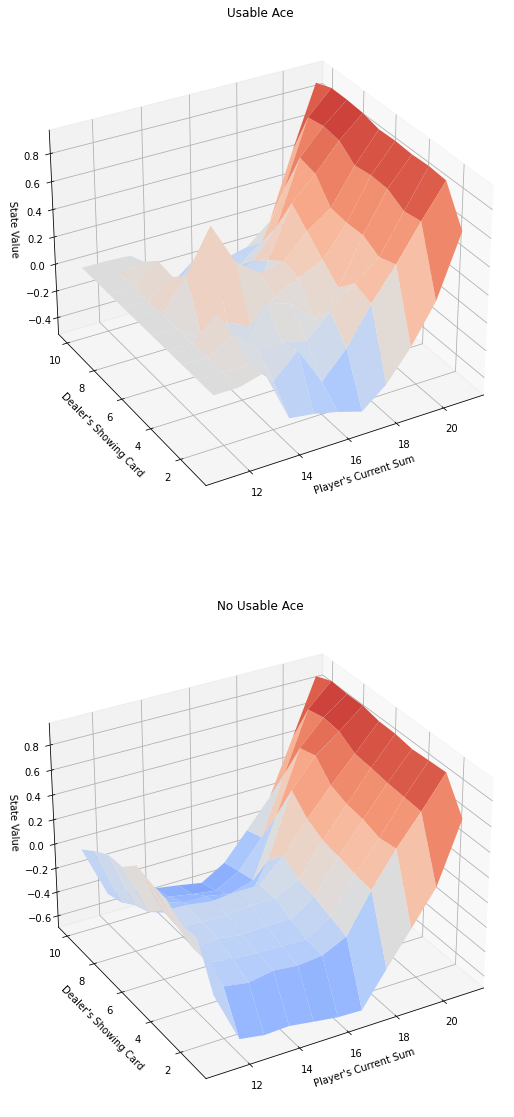

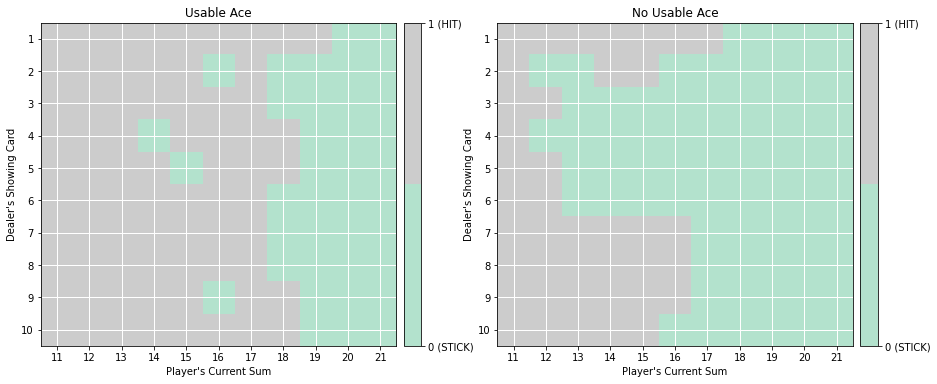

In [11]:
#Obtain and plot optimal policy and state value function from the converged action value function
policy={}
V={}
for i in Q:
    policy[i] = np.argmax(Q[i])
    V[i] = np.max(Q[i])

plot(V)
plot_policy(policy)  